In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# 1. Preparing the dataset

In [204]:
df = pd.read_csv('./final_data.csv', parse_dates=['Date'], index_col='Date')

In [205]:
df.sort_index(inplace=True)

In [206]:
df.head()

,Note,Amount,Cash Flow,Category,Month,Day,Year
Date,,,,,,,
2015-01-01,share auto - hospital to brc station,10.0,Expense,Transport,1,1,2015
2015-01-01,bus - brc to Place H,30.0,Expense,Transport,1,1,2015
2015-01-01,share auto - Place H to Place T base,20.0,Expense,Transport,1,1,2015
2015-01-01,share jeep - Place T base to top,20.0,Expense,Transport,1,1,2015
2015-01-01,ropeway Place T to and fro,142.0,Expense,Transport,1,1,2015


In [207]:
df = df.resample('W').sum()
df = df.asfreq('W')

In [208]:
weekly_spending = df.Amount

In [209]:
weekly_spending.shape

(206,)

<Axes: xlabel='Date'>

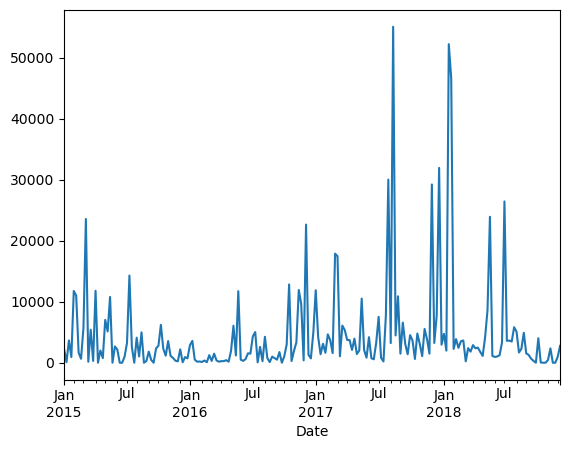

In [210]:
weekly_spending.plot()

In [211]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
sr = pd.Series(np.squeeze(pt.fit_transform(np.expand_dims(weekly_spending, 1))))
sr.index = weekly_spending.index
weekly_spending = sr


In [212]:
# Removing outliers

z_score = (weekly_spending - weekly_spending.mean()) /weekly_spending.std()
weekly_spending = weekly_spending[z_score < 2]

In [213]:
weekly_spending.shape

(199,)

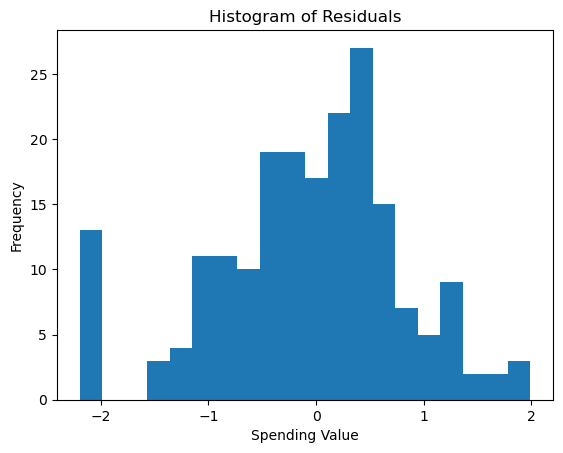

In [214]:
plt.hist(weekly_spending, bins=20)
plt.title("Histogram of Residuals")
plt.xlabel("Spending Value")
plt.ylabel("Frequency")
plt.show()


In [215]:
weekly_spending = weekly_spending.asfreq('W')

In [216]:
weekly_spending = weekly_spending.interpolate()

<Axes: xlabel='Date'>

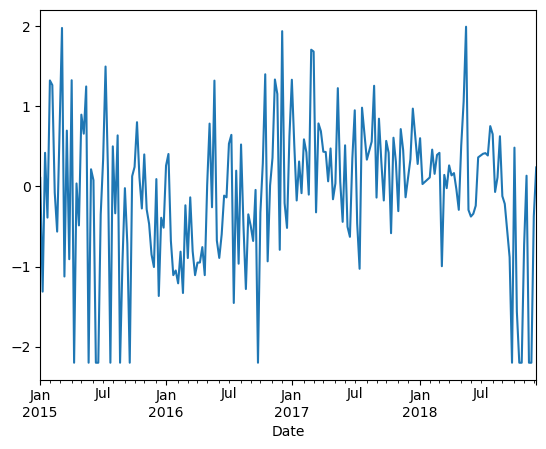

In [217]:
weekly_spending.plot()

In [218]:
def create_sequences(data, window_size):
    X , y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [219]:
SEQ_LEN = 10
X, y = create_sequences(weekly_spending, SEQ_LEN)

C:\Users\JARVIS\AppData\Local\Temp\ipykernel_1080\177203607.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+window_size])


In [220]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [221]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [222]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# 2. Building the model

In [223]:
from tensorflow.keras import Sequential

model = Sequential([
    tf.keras.layers.LSTM(32, input_shape=(SEQ_LEN, 1)),

    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(1)


])

In [224]:
model.compile(loss='mse', optimizer='adam')

In [225]:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')

In [226]:
model.fit(train_ds, validation_data=test_ds, epochs=90, callbacks=[earlystopping])

Epoch 1/90


5/5 [==============================] - 2s 97ms/step - loss: 0.7952 - val_loss: 1.0055
Epoch 2/90
5/5 [==============================] - 0s 10ms/step - loss: 0.7259 - val_loss: 0.8977
Epoch 3/90
5/5 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.8282
Epoch 4/90
5/5 [==============================] - 0s 10ms/step - loss: 0.6721 - val_loss: 0.7916
Epoch 5/90
5/5 [==============================] - 0s 11ms/step - loss: 0.6689 - val_loss: 0.7796
Epoch 6/90
5/5 [==============================] - 0s 13ms/step - loss: 0.6714 - val_loss: 0.7803
Epoch 7/90
5/5 [==============================] - 0s 14ms/step - loss: 0.6722 - val_loss: 0.7856
Epoch 8/90
5/5 [==============================] - 0s 19ms/step - loss: 0.6710 - val_loss: 0.7923


# 3. Evaluation

In [227]:
pred = model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


In [228]:
forecast = pd.Series(np.squeeze(pred))

In [229]:
forecast_original = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(forecast, axis=1))))
y_test = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(y_test, axis=1))))

forecast_original.index = df[-40:].index
y_test.index = df[-40:].index

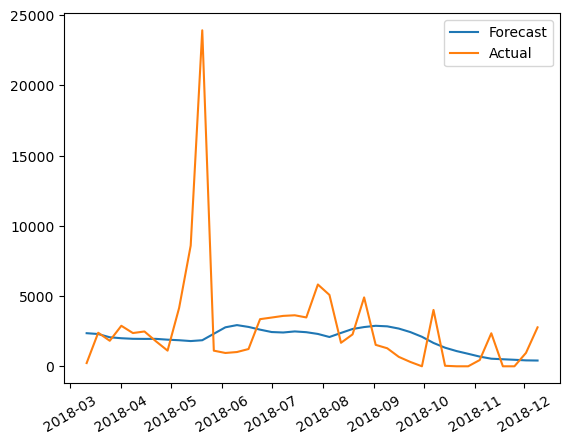

In [230]:

plt.plot(forecast_original, label='Forecast')
plt.plot(y_test, label='Actual')
plt.xticks(rotation=30)
plt.legend()

# 4. Forecast

In [231]:
# Start with the last sequence from your data
last_seq = weekly_spending[-SEQ_LEN:]
predictions = []

# Forecast next 12 months
for _ in range(12):
    input_seq = np.expand_dims(last_seq, 0)
    pred = model.predict(input_seq, verbose=0)
    predictions.append(pred[0][0])
    print(pred)
    last_seq = np.concatenate([last_seq[1:], pred[0]])  # slide the window


[[-0.70435876]]
[[-0.7181725]]
[[-0.6626459]]
[[-0.59383315]]
[[-0.52679193]]
[[-0.5132496]]
[[-0.5299663]]
[[-0.4580293]]
[[-0.38571593]]
[[-0.38967332]]
[[-0.41500244]]
[[-0.39431807]]


In [232]:
predicted_values = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(predictions, axis=1))))
sr = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(weekly_spending, axis=1))))
sr.index = weekly_spending.index
weekly_spending = sr
# Create future dates



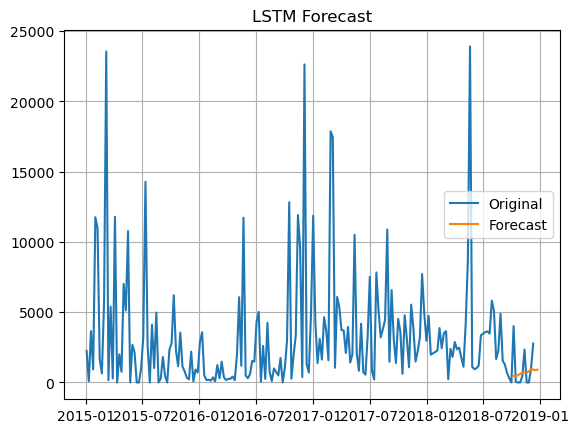

In [233]:
future_dates = pd.date_range(start=df.index[-SEQ_LEN], periods=12, freq='W')

# Plot
plt.plot(weekly_spending, label="Original")
plt.plot(future_dates, predicted_values, label="Forecast")
plt.title("LSTM Forecast")
plt.legend()
plt.grid(True)
plt.show()